<a href="https://colab.research.google.com/github/rohanjsheth/DiffusionModels/blob/main/ToyDiffusionMINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install diffusers

In [18]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from diffusers import DDPMScheduler, UNet2DModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 40.6MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.74MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 5, 1, 6, 5, 1, 2, 6])


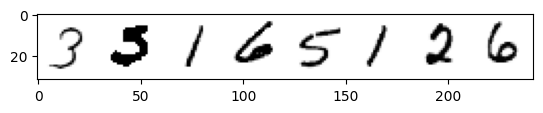

In [4]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [5]:
def corrupt(img, amount):
  noise = torch.rand_like(img)
  amount = amount.view(-1, 1, 1, 1)
  return img*(1-amount) + noise*amount

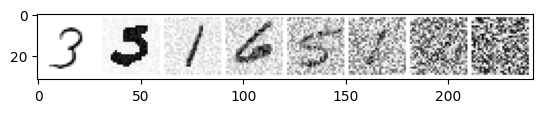

In [6]:
corr = corrupt(x, torch.linspace(0, 1, x.shape[0]))
plt.imshow(torchvision.utils.make_grid(corr)[0], cmap='Greys');

In [7]:
#UNET
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
      super().__init__()
      self.down = torch.nn.ModuleList([
          nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
          nn.Conv2d(32, 64, kernel_size=5, padding=2),
          nn.Conv2d(64, 64, kernel_size=5, padding=2)
      ])
      self.up = torch.nn.ModuleList([
          nn.Conv2d(64, 64, kernel_size=5, padding=2),
          nn.Conv2d(64, 32, kernel_size=5, padding=2),
          nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
      ])
      self.activation = nn.SiLU()
      self.downscale = nn.MaxPool2d(2)
      self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
      h = []
      for i, l in enumerate(self.down):
        #print(f"x_in: {x.shape}")
        x = self.activation(l(x))
        if i < 2:
          h.append(x)
          x = self.downscale(x)
      for i, l in enumerate(self.up):
        #print(f"x_out: {x.shape}")
        #print(f"h: {h[-1].shape}")
        if i > 0:
          x = self.upscale(x)
          x += h.pop()
        x = self.activation(l(x))
      return x

In [8]:
net = BasicUNet()
x = torch.rand(1, 1, 28, 28)
net(x).shape

torch.Size([1, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.026704
Finished epoch 1. Average loss for this epoch: 0.020332
Finished epoch 2. Average loss for this epoch: 0.018513
Finished epoch 3. Average loss for this epoch: 0.017516
Finished epoch 4. Average loss for this epoch: 0.016927
Finished epoch 5. Average loss for this epoch: 0.016490
Finished epoch 6. Average loss for this epoch: 0.016193
Finished epoch 7. Average loss for this epoch: 0.015862
Finished epoch 8. Average loss for this epoch: 0.015356
Finished epoch 9. Average loss for this epoch: 0.014832


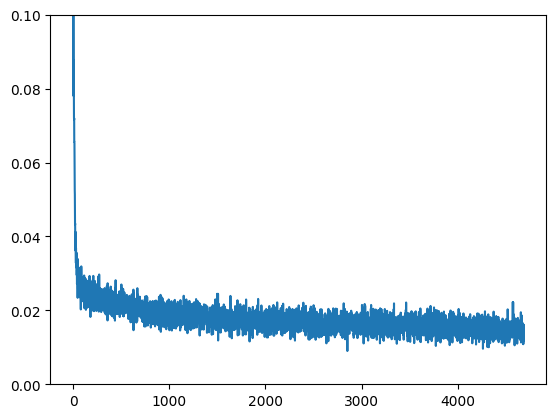

In [49]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 10

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
  for x, y in train_dataloader:
    x = x.to(device)
    noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
    noisy_x = corrupt(x, noise_amount)

    pred = net(noisy_x)
    loss = loss_fn(pred, x)

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item())

  avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
  print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(losses)
plt.ylim(0, 0.1);

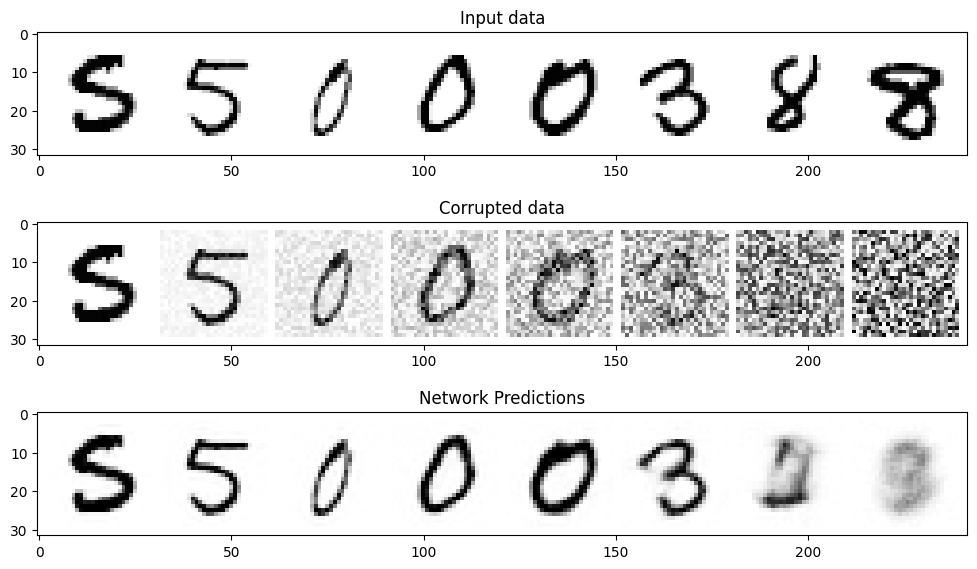

In [50]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

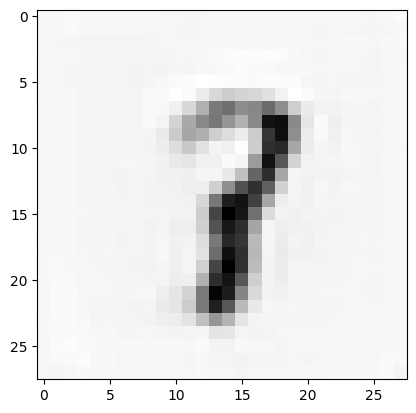

In [54]:
def iterative_sample():
  x = torch.rand(1, 1, 28, 28)
  x = x.to(device)
  for i in range(5):
    x = (1-(i/5))*net(x)+(i/5)*x
  x = x.detach().cpu()
  plt.imshow(x.squeeze(), cmap='gray_r')

iterative_sample()

In [33]:
net = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)

In [41]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

Finished epoch 0. Average loss for this epoch: 0.018258
Finished epoch 1. Average loss for this epoch: 0.012488
Finished epoch 2. Average loss for this epoch: 0.011324
Finished epoch 3. Average loss for this epoch: 0.010913
Finished epoch 4. Average loss for this epoch: 0.010602
Finished epoch 5. Average loss for this epoch: 0.010366
Finished epoch 6. Average loss for this epoch: 0.010202
Finished epoch 7. Average loss for this epoch: 0.010032
Finished epoch 8. Average loss for this epoch: 0.009815
Finished epoch 9. Average loss for this epoch: 0.009669


Text(0.5, 1.0, 'Loss over time')

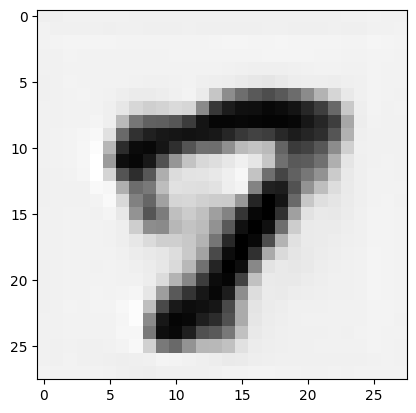

In [47]:
def iterative_sample():
  x = torch.rand(1, 1, 28, 28)
  x = x.to(device)
  for i in range(3):
    x = (1-(i/3))*net(x, 0).sample+(i/3)*x
  x = x.detach().cpu()
  plt.imshow(x.squeeze(), cmap='gray_r')

iterative_sample()